In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nisargpatel2466/brain-tumer-dataset")

print("Path to dataset files:", path)

100%|██████████| 153M/153M [00:05<00:00, 27.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/nisargpatel2466/brain-tumer-dataset/versions/3


In [2]:
import os

# The 'path' variable holds the base path to the downloaded dataset.
# The actual data is likely in a 'Data' subdirectory within an 'archive' folder.
DATA_PATH = os.path.join(path, 'archive', 'Data')
os.listdir(DATA_PATH)

['meningioma_tumor', 'normal', 'glioma_tumor', 'pituitary_tumor']

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import os

# Image transformations
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])


In [4]:
# Base path to dataset
DATA_PATH = os.path.join(path, 'archive', 'Data')

# Load dataset using ImageFolder
dataset = datasets.ImageFolder(root=DATA_PATH, transform=transform)

# Split dataset: 80% train, 20% test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")


Train samples: 2476, Test samples: 620


In [5]:
class BrainTumorCNN(nn.Module):
    def __init__(self):
        super(BrainTumorCNN, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(128*16*16, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 4)  # 4 classes: pituitary, meningioma, glioma, normal
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        return x

model = BrainTumorCNN()


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [12]:
num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/3] Loss: 0.5835
Epoch [2/3] Loss: 0.4378
Epoch [3/3] Loss: 0.3549


In [13]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 84.03%


In [14]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


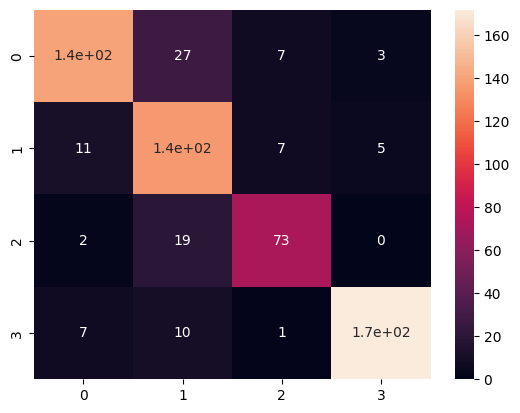

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True)
plt.show()


In [16]:
torch.save(model.state_dict(), "cnn_model.pth")


In [17]:
model.eval()
with torch.no_grad():
    image = test_dataset[0][0].unsqueeze(0).to(device)  # single image
    output = model(image)
    _, predicted = torch.max(output, 1)
    print("Predicted class:", predicted.item())


Predicted class: 0
